# 라이브러리

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression          
from sklearn.model_selection import cross_val_score

plt.rcParams['font.family'] = 'Malgun Gothic'
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [84]:
df = pd.read_csv('/Users/t2024-m0220/Documents/GitHub/practical_project/csv/스마트팜_수정데이터.csv', encoding="cp949")

In [85]:
df.head()

,농장아이디,개체번호,축종코드,제조사 아이디,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,체세포,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,수집건수
0,20278,20130816010079,D00,agrirobotech,2021-09-01 6:52,16,2021-09-01 6:52,2021-09-01 7:04,1,7.1,NaN,N,39.9,4.1,3.3,1.5,20210902,1
1,20278,20130816010079,D00,agrirobotech,2021-09-01 17:02,17,2021-09-01 17:02,2021-09-01 17:11,2,6.8,NaN,N,40.2,4.5,3.2,2.1,20210902,1
2,20278,20130816010079,D00,agrirobotech,2021-09-02 1:41,14,2021-09-02 1:41,2021-09-02 1:51,1,6.8,NaN,N,39.9,4.8,3.1,1.9,20210903,1
3,20278,20130816010079,D00,agrirobotech,2021-09-02 7:28,10,2021-09-02 7:28,2021-09-02 7:36,2,6.8,NaN,N,39.6,5.0,3.1,1.7,20210903,1
4,20278,20130816010079,D00,agrirobotech,2021-09-02 14:33,11,2021-09-02 14:33,2021-09-02 14:45,3,6.8,NaN,N,40.0,4.7,3.2,1.3,20210903,1


In [86]:
df["농장아이디"].value_counts()

농장아이디
20338    6226
20261    6226
20264    4396
20279    3053
21133    3010
20332    2817
20278    2198
Name: count, dtype: int64

In [87]:
print(df.shape)

(27926, 18)


# 데이터 전처리

## 농장아이디 "20261"은 더블링으로 drop

In [88]:
df_drop = df[df["농장아이디"]==20261].index
df.drop(df_drop, inplace=True)

In [89]:
df["농장아이디"].value_counts()

농장아이디
20338    6226
20264    4396
20279    3053
21133    3010
20332    2817
20278    2198
Name: count, dtype: int64

## 불필요한 컬럼 제거 (동일한 행, 동일한 컬럼, null값 컬럼)

In [90]:
df.drop("체세포", axis=1, inplace=True)
df.drop("수집건수", axis=1, inplace=True)
df.drop("측정일시", axis=1, inplace=True)
df.drop("축종코드", axis=1, inplace=True)
df.drop("제조사 아이디", axis=1, inplace=True)
df.drop("수집일자", axis=1, inplace=True)

In [91]:
df.head()

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
0,20278,20130816010079,16,2021-09-01 6:52,2021-09-01 7:04,1,7.1,N,39.9,4.1,3.3,1.5
1,20278,20130816010079,17,2021-09-01 17:02,2021-09-01 17:11,2,6.8,N,40.2,4.5,3.2,2.1
2,20278,20130816010079,14,2021-09-02 1:41,2021-09-02 1:51,1,6.8,N,39.9,4.8,3.1,1.9
3,20278,20130816010079,10,2021-09-02 7:28,2021-09-02 7:36,2,6.8,N,39.6,5.0,3.1,1.7
4,20278,20130816010079,11,2021-09-02 14:33,2021-09-02 14:45,3,6.8,N,40.0,4.7,3.2,1.3


# 데이터 타입 변환

In [92]:
# 착유시작, 종료일시 datetime으로 전처리

df["착유시작일시"] = pd.to_datetime(df["착유시작일시"], format="%Y-%m-%d %H:%M")
df["착유종료일시"] = pd.to_datetime(df["착유종료일시"], format="%Y-%m-%d %H:%M")

In [93]:
# 혈액흐름 전처리

df["혈액흐름"] = df["혈액흐름"].apply(lambda x : 0 if x == "N" else 1)

In [94]:
df.head()

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
0,20278,20130816010079,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5
1,20278,20130816010079,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1
2,20278,20130816010079,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9
3,20278,20130816010079,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7
4,20278,20130816010079,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3


# 파생변수 생성

In [95]:
df["착유시간"] = df["착유종료일시"] - df["착유시작일시"]
df["착유시간"]  = df["착유시간"].dt.total_seconds() / 60  # 분 단위로 변환

In [96]:
# 개체별 나이 (개체번호 앞 7자리는 생년월일)

df_birth = df['개체번호'].astype(str).str[:8]
df_birthdt = pd.to_datetime(df_birth, format='%Y%m%d', errors='coerce')

def calculate_age(birth_date, current_date):

    # 만 나이 계산 로직
    # 현재 연도 - 출생 연도 - 불리언(생일이 현재 날짜보다 뒤에 있으면 1 빼기)
    age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    return age

current_analysis_date = datetime(2021, 10, 1)
df['나이'] = df_birthdt.apply(lambda x: calculate_age(x, current_analysis_date))

## 여기에 무언가 문제가.. 측정일이 무엇이죠??? 개체별 착유일수 보려고...? 횟수가 더 낫지 않나요?

In [97]:
# 개체별 착유일수

df_count2 = df.groupby("개체번호")["착유시작일시"].nunique().reset_index()
df_count2.rename(columns={"착유시작일시": "개체별 착유일수"}, inplace=True)
df = df.merge(df_count2, on="개체번호", how="left")

In [98]:
# P/F 비율 (유단백/유지방 비율)

df["P/F_ratio"] = df["유단백"]/ df["유지방"]

In [99]:
# 공기흐름 비율 (착유시간에 따른 공기흐름)

df["공기흐름_비율"] = df["공기흐름"] / df["착유시간"]

In [100]:
df.head()

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간,나이,개체별 착유일수,P/F_ratio,공기흐름_비율
0,20278,20130816010079,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5,12.0,8,49,0.804878,0.125000
1,20278,20130816010079,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1,9.0,8,49,0.711111,0.233333
2,20278,20130816010079,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9,10.0,8,49,0.645833,0.190000
3,20278,20130816010079,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7,8.0,8,49,0.620000,0.212500
4,20278,20130816010079,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3,12.0,8,49,0.680851,0.108333


# 결측치 제거

## 착유량 0인 애들은 ??여전히 7개 존재

In [111]:
# 유지방, 유단백 결측치 제거 -> 같이 존재하기 때문에 유지방으로 제거

null_fat = df["유지방"].isnull()
null_fat_index = null_fat[null_fat].index
df.drop(null_fat_index, inplace=True)

In [112]:
df.head()

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간,나이,개체별 착유일수,P/F_ratio,공기흐름_비율
0,20278,20130816010079,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5,12.0,8,49,0.804878,0.125000
1,20278,20130816010079,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1,9.0,8,49,0.711111,0.233333
2,20278,20130816010079,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9,10.0,8,49,0.645833,0.190000
3,20278,20130816010079,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7,8.0,8,49,0.620000,0.212500
4,20278,20130816010079,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3,12.0,8,49,0.680851,0.108333


In [113]:
df[df["착유량"] == 0]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간,나이,개체별 착유일수,P/F_ratio,공기흐름_비율
3213,20338,20161021020021,0,2021-09-14 16:39:00,2021-09-14 16:42:00,2,8.2,0,36.9,5.9,3.7,0.6,3.0,4,25,0.627119,0.20
3216,20338,20161021020021,0,2021-09-17 04:38:00,2021-09-17 04:42:00,1,9.3,0,35.6,6.7,3.2,0.4,4.0,4,25,0.477612,0.10
3217,20338,20161021020021,0,2021-09-19 16:21:00,2021-09-19 16:26:00,1,7.6,0,35.8,6.2,3.8,0.7,5.0,4,25,0.612903,0.14
12717,20332,20191014020056,0,2021-09-16 18:13:00,2021-09-16 18:22:00,1,3.8,0,37.1,10.5,4.6,0.0,9.0,1,19,0.438095,0.00
12718,21133,20191014010100,0,2021-09-16 18:13:00,2021-09-16 18:22:00,1,3.8,0,37.1,10.5,4.6,0.0,9.0,1,19,0.438095,0.00
14091,21133,20161119010018,0,2021-09-14 18:38:00,2021-09-14 18:43:00,2,3.0,0,32.7,1.2,3.3,0.3,5.0,4,24,2.750000,0.06
14092,20332,20161002020124,0,2021-09-14 18:38:00,2021-09-14 18:43:00,2,3.0,0,32.7,1.2,3.3,0.3,5.0,4,24,2.750000,0.06


In [117]:
df["유지방"].isnull().value_counts()

유지방
False    21658
Name: count, dtype: int64

In [119]:
df.shape

(21658, 17)

In [124]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# macOS 한글 폰트 설정
rcParams['font.family'] = 'AppleGothic'
rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [125]:
# 1) 이상치 제거할 한국어 컬럼 리스트
outlier_cols = [
    '착유량',
    '착유회차',
    '전도도',
    '온도',
    '유지방',
    '유단백',
    '공기흐름',
    '착유시간'
]
# 2) 각 칼럼별 IQR 기반 하한·상한 계산 (3.0 × IQR)
bounds = {}
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    bounds[col] = (lower, upper)
    print(f"{col} 하한: {lower:.2f}, 상한: {upper:.2f}")
# 3) 모든 칼럼이 허용 범위에 있는 행만 남기기
mask = pd.Series(True, index=df.index)
for col, (lower, upper) in bounds.items():
    mask &= df[col].between(lower, upper)
before = len(df)
df_clean = df.loc[mask].copy()
after = len(df_clean)
print(f"이상치 제거 전 행 수: {before}")
print(f"이상치 제거 후 행 수: {after}")
print(f"제거된 행 수: {before - after}")
# → 결과는 df_clean에 저장됩니다.

착유량 하한: -6.00, 상한: 29.00
착유회차 하한: -5.00, 상한: 9.00
전도도 하한: 5.20, 상한: 8.70
온도 하한: 36.50, 상한: 42.10
유지방 하한: 0.80, 상한: 7.10
유단백 하한: 2.10, 상한: 4.20
공기흐름 하한: -2.20, 상한: 8.30
착유시간 하한: -4.00, 상한: 17.00
이상치 제거 전 행 수: 21658
이상치 제거 후 행 수: 21050
제거된 행 수: 608


## 측정일 제외했습니다

학습 데이터 X_train 형태: (16840, 7)
검증 데이터 X_test 형태: (4210, 7)
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 2.06
Root Mean Squared Error (RMSE): 1.43
R-squared (R2): 0.84
Mean Absolute Percentage Error (MAPE): 69163830476800.00%
----------------------------------------
교차검증 R2: 0.8402
과적합 정도: 0.0027

--- 피처 중요도 순위 ---
     Feature  Importance
0       개체번호    0.488646
6       착유시간    0.215634
1    공기흐름_비율    0.070612
5      농장아이디    0.065172
3   개체별 착유일수    0.058830
2  P/F_ratio    0.054363
4       착유회차    0.046743


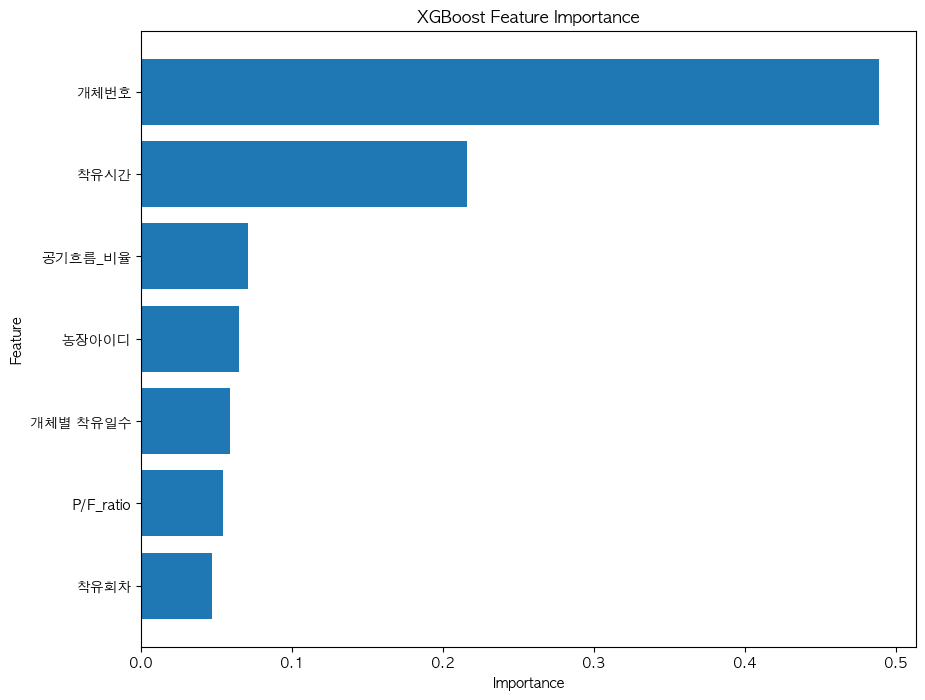

In [126]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수
X = df_clean[["개체번호","공기흐름_비율","P/F_ratio","개체별 착유일수","착유회차","농장아이디","착유시간"]]
y = df_clean['착유량']
# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)
cat_feats = ['농장아이디','개체번호']
te = TargetEncoder(cols=cat_feats)
X_train_encoded = te.fit_transform(X_train, y_train)
X_test_encoded = te.transform(X_test)
param_grid = {
    'n_estimators': [250, 300, 350, 400],
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [4, 5, 6],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'reg_alpha': [0.3, 0.5, 0.7],  # L1 정규화
    'reg_lambda': [0.3, 0.5, 0.7]  # L2 정규화
}
# --- XGBoost 모델 생성 및 학습 ---
xgb_model = xgb.XGBRegressor(random_state=42 , verbosity=0)
random_search = RandomizedSearchCV(
    xgb_model, param_grid, n_iter=30,
    cv=5, scoring='r2', random_state=42, n_jobs=-1
)
random_search.fit(X_train_encoded, y_train)
best_model = random_search.best_estimator_
# 검증 세트에 대한 예측
y_pred = random_search.predict(X_test_encoded)
# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100 # %로 변환
print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("-" * 40)
# 과적합 확인
cv_scores3 = cross_val_score(best_model, X_train_encoded, y_train, cv=5, scoring='r2')
print(f"교차검증 R2: {cv_scores3.mean():.4f}")
print(f"과적합 정도: {abs(cv_scores3.mean() - r2):.4f}")
# --- 피처 중요도 체크 코드 시작 ---
# 피처(특성)의 이름 리스트 가져오기
feature_names = X_test_encoded.columns
# best_model에서 피처 중요도 점수 가져오기
importance_scores = best_model.feature_importances_
# 피처 이름과 중요도 점수를 데이터프레임으로 만들기
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})
# 중요도 점수가 높은 순서대로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\n--- 피처 중요도 순위 ---")
print(feature_importance_df)
# 중요도를 시각화하여 확인 (선택 사항)
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis() # 가장 중요한 피처가 맨 위에 오도록 정렬
plt.show()